# (baseline development) Silicon per M2 Calculations

This journal documents the methods and assumptions made to create a baseline material file for silicon.

## Mass per M2

The mass of silicon contained in a PV module is dependent on the size, thickness and number of cells in an average module. Since there is a range of sizes and number of cells per module, we will attempt a weighted average. These weighted averages are based on ITRPV data, which goes back to 2010, Fraunhofer data back to 1990, and 

In [23]:
import os
from pathlib import Path

supportingmaterial = str(Path().resolve().parent.parent / 'PV_DEMICE' / 'baselines' / 'SupportingMaterial')
print ("Your Results will be stored in %s" % supportingmaterial)

Your Results will be stored in C:\Users\Silvana\Documents\GitHub\CircularEconomy-MassFlowCalculator\PV_DEMICE\TEMP


In [2]:
import numpy as np
import pandas as pd
import os,sys
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
plt.rcParams['figure.figsize'] = (12, 8)

density_si = 2.3290 #g/cm^3 from Wikipedia of Silicon (https://en.wikipedia.org/wiki/Silicon) 
#it might be better to have mono-Si and multi-Si densities, including dopants, 
#but that density is not readily available

A Fraunhofer report indicates that in 1990, wafers were 400 micron thick, decreasing to the more modern 180 micron thickness by 2008. ITRPVs back to 2010 indicate that 156 mm x 156mm was the standard size wafer through 2015.

In [3]:
#weighted average for wafer size 2016 through 2030
#2016
wafer2016mcsi = (0.90*156 + 0.10*156.75)/100
wafer2016monosi = (0.55*156 + 0.45*156.75)/100
wafer2016avg = 0.9*wafer2016mcsi + 0.1*wafer2016monosi
print("Average Wafer size in 2016 was", wafer2016avg, "cm on a side")

Average Wafer size in 2016 was 1.5610125000000001 cm on a side


In [4]:
#now lets try to do this for 2019 through 2030 all at once with dataframes
#taking the average of the ranges specified in ITRPVs

#first we input the market share data for mcSi and monoSi, read in from csv
cwd = os.getcwd() #grabs current working directory
mrktshr_cellsize = pd.read_csv(r'..\..\PV_DEMICE\baselines\SupportingMaterial/MarketShare_CellSize.csv', index_col='Year')
mrktshr_cellsize /=100 #turn whole numbers into decimal percentages
#print(mrktshr_cellsize)

#then split them into two dataframes for later computations
dfmarketshare_mcSi = mrktshr_cellsize.filter(regex = 'mcSi')
dfmarketshare_monoSi = mrktshr_cellsize.filter(regex = 'monoSi')
#adjust column names for matching computation later
dfmarketshare_mcSi.columns = ['share156','share156.75','share157.75','share163','share166up']
dfmarketshare_monoSi.columns = ['share156','share156.75','share157.75','share163','share166up']

print(dfmarketshare_mcSi)
print(dfmarketshare_monoSi)


      share156  share156.75  share157.75  share163  share166up
Year                                                          
1995      1.00          NaN          NaN       NaN         NaN
1996      1.00          NaN          NaN       NaN         NaN
1997      1.00          NaN          NaN       NaN         NaN
1998      1.00          NaN          NaN       NaN         NaN
1999      1.00          NaN          NaN       NaN         NaN
2000      1.00          NaN          NaN       NaN         NaN
2001      1.00          NaN          NaN       NaN         NaN
2002      1.00          NaN          NaN       NaN         NaN
2003      1.00          NaN          NaN       NaN         NaN
2004      1.00          NaN          NaN       NaN         NaN
2005      1.00          NaN          NaN       NaN         NaN
2006      1.00          NaN          NaN       NaN         NaN
2007      1.00          NaN          NaN       NaN         NaN
2008      1.00          NaN          NaN       NaN     

Interpolate marketshare for missing years in ITRPV 2020 predictions
----
choosing to interpolate market share of different sizes rather than cell size because this should be more basedin technology - i.e. crystals only grow certain sizes. Additionally, it is more helpful to understand the impact silicon usage by keeping cell size and marketshare seperate.

In [5]:
#interpolate for missing marketshare data
##the interpolate function returns a view of the df, doesn't modify the df itself
##therefore you have to set the old df, or a new one = the df.interpolate function
dfmarketshare_mcSi=dfmarketshare_mcSi.interpolate(method='linear',axis=0,limit=2,limit_area='inside')
dfmarketshare_monoSi=dfmarketshare_monoSi.interpolate(method='linear',axis=0,limit=2,limit_area='inside')

#fill remaining NaN/outside with 0 (i.e., no market share)
#dfmarketshare_mcSi=dfmarketshare_mcSi.fillna(0.0)
#dfmarketshare_monoSi=dfmarketshare_monoSi.fillna(0.0)

print(dfmarketshare_mcSi)
print(dfmarketshare_monoSi)

      share156  share156.75  share157.75  share163  share166up
Year                                                          
1995      1.00     0.000000     0.000000  0.000000    0.000000
1996      1.00     0.000000     0.000000  0.000000    0.000000
1997      1.00     0.000000     0.000000  0.000000    0.000000
1998      1.00     0.000000     0.000000  0.000000    0.000000
1999      1.00     0.000000     0.000000  0.000000    0.000000
2000      1.00     0.000000     0.000000  0.000000    0.000000
2001      1.00     0.000000     0.000000  0.000000    0.000000
2002      1.00     0.000000     0.000000  0.000000    0.000000
2003      1.00     0.000000     0.000000  0.000000    0.000000
2004      1.00     0.000000     0.000000  0.000000    0.000000
2005      1.00     0.000000     0.000000  0.000000    0.000000
2006      1.00     0.000000     0.000000  0.000000    0.000000
2007      1.00     0.000000     0.000000  0.000000    0.000000
2008      1.00     0.000000     0.000000  0.000000    0

In [6]:
#multiply each marketshare dataframe column by it's respective size
#dfmarketshare_mcSi.share156 *=156 #this is a slow way to multiply each column by its respective size

cellsizes = {'share156':156,
            'share156.75':156.75,
            'share157.75':157.75,
            'share163':163.875,
            'share166up':166} #dictionary of the average cell dimension for each market share bin (ITRPV 2020)

#multiply cell dimensions by their market share to get a weighted average
##this is where the column names needed to match
df_scalecell_mcSi = dfmarketshare_mcSi.mul(cellsizes,'columns')
df_scalecell_monoSi = dfmarketshare_monoSi.mul(cellsizes,'columns')

print(df_scalecell_mcSi)
print(df_scalecell_monoSi)

      share156  share156.75  share157.75  share163  share166up
Year                                                          
1995    156.00      0.00000     0.000000    0.0000    0.000000
1996    156.00      0.00000     0.000000    0.0000    0.000000
1997    156.00      0.00000     0.000000    0.0000    0.000000
1998    156.00      0.00000     0.000000    0.0000    0.000000
1999    156.00      0.00000     0.000000    0.0000    0.000000
2000    156.00      0.00000     0.000000    0.0000    0.000000
2001    156.00      0.00000     0.000000    0.0000    0.000000
2002    156.00      0.00000     0.000000    0.0000    0.000000
2003    156.00      0.00000     0.000000    0.0000    0.000000
2004    156.00      0.00000     0.000000    0.0000    0.000000
2005    156.00      0.00000     0.000000    0.0000    0.000000
2006    156.00      0.00000     0.000000    0.0000    0.000000
2007    156.00      0.00000     0.000000    0.0000    0.000000
2008    156.00      0.00000     0.000000    0.0000    0

In [22]:
#now add the columns together to get the weighted average cell size for each year for each technology
df_avgcell_mcSi = pd.DataFrame(df_scalecell_mcSi.agg("sum", axis="columns"))
df_avgcell_monoSi = pd.DataFrame(df_scalecell_monoSi.agg("sum", axis="columns")) #agg functions return a series not a dictionary
#print(df_avgcell_mcSi)

#join the two dataframes into single one with two columns
df_avgcell = pd.concat([df_avgcell_monoSi,df_avgcell_mcSi], axis=1) #concatinate on the columns axis
df_avgcell.columns = ['monoSi','mcSi'] #name the columns
#print(df_avgcell)


# However, we know that it wasn't 156 mm back to 1995, but exact records are lacking on what cells sizes were. A mention of a companies' new manufacturing line producing 125 mm mono-Si in 1993 can be found in IEA PVPS documentation, and Martin Green 2000 calls out 100 mm to 150 mm manufacturing. Therefore, we will say that cell sizes in 1995 were 125 mm, and in 2000 were 150 mm, and use linear iterpolation from 1995 to 2000, and 2000 to 2010 (where ITRPV data starts).


In [ ]:
# In[88]:


#turn zeros back into NaN
df_avgcell.replace(0.0, np.NaN, inplace=True)

#write over 1995 and 2000 data - caution ASSUMPTIONS
df_avgcell['monoSi'][1995]=125.00
df_avgcell['monoSi'][2000]=150.00
df_avgcell['mcSi'][1995]=125.00
df_avgcell['mcSi'][2000]=150.00

#linearly interpolate 
df_avgcell = df_avgcell.interpolate(method='linear',axis=0,limit_area='inside')
print(df_avgcell)

Now we have an average cell dimension for mc-Si and mono-Si for 1995 through 2030. 

## Marketshare Data Manipulation

Next, we apply the marketshare of mc-Si vs mono-Si to get the average cell dimension for the year. Market share of mc-Si vs mono-Si is taken from LBNL "Tracking the Sun" report (warning: this is non-utility scale data i.e. <5MW, and is from 2002-2018), from Mints 2019 SPV report, from ITRPVs, and old papers (Costello & Rappaport 1980, Maycock 2003 & 2005).

In [8]:
#read in a csv that was copied from CE Data google sheet
cwd = os.getcwd() #grabs current working directory

techmarketshare = pd.read_csv(r'..\..\PV_DEMICE\baselines\SupportingMaterial\ModuleType_MarketShare.csv',index_col='Year')
#this file path navigates from current working directory back up 2 folders, and over to the csv
techmarketshare /=100 #turn whole numbers into decimal percentages
print(techmarketshare)

      monoSi_LBNL  mcSi_LBNL  otherSi_LBNL  monoSi_Mints  mcSi_Mints  \
Year                                                                   
1980          NaN        NaN           NaN           NaN         NaN   
1981          NaN        NaN           NaN           NaN         NaN   
1982          NaN        NaN           NaN           NaN         NaN   
1983          NaN        NaN           NaN           NaN         NaN   
1984          NaN        NaN           NaN           NaN         NaN   
1985          NaN        NaN           NaN           NaN         NaN   
1986          NaN        NaN           NaN           NaN         NaN   
1987          NaN        NaN           NaN           NaN         NaN   
1988          NaN        NaN           NaN           NaN         NaN   
1989          NaN        NaN           NaN           NaN         NaN   
1990          NaN        NaN           NaN           NaN         NaN   
1991          NaN        NaN           NaN           NaN        

2030          0.94        0.06  


#### create a harmonization of annual market share, and interpolate

In [9]:
# first, create a single value of tech market share in each year or NaN
#split mcSi and monoSi
mcSi_cols = techmarketshare.filter(regex = 'mcSi')
monoSi_cols = techmarketshare.filter(regex = 'mono')

#show where the data is coming from graphically
#plt.plot(mcSi_cols,'.')
monoSikeys = monoSi_cols.columns
labelnames = [e[7:] for e in monoSikeys] #e is a random variable to iterate through the elements of the array
mcSikeys = mcSi_cols.columns
labelnames_mcSi = [e[5:] for e in mcSikeys]
#print(monoSikeys)

Text(0, 0.5, 'Market Share (%)')

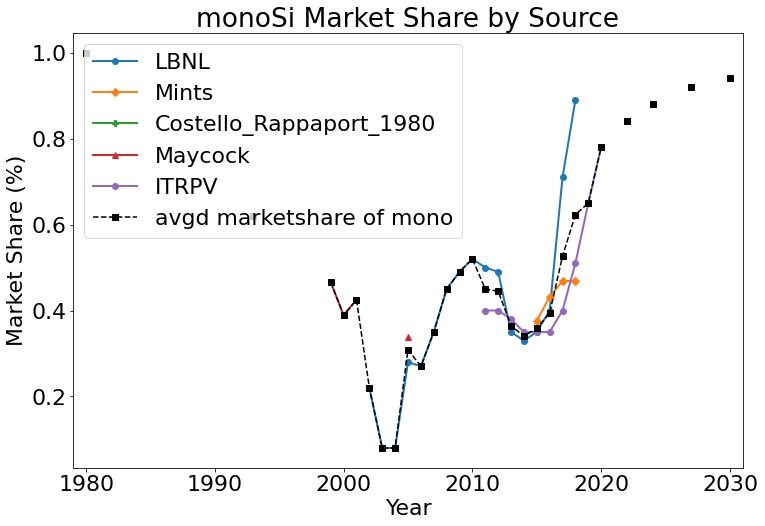

In [10]:
#aggregate all the columns of mono or mcSi into one averaged market share
est_mktshr_mcSi = pd.DataFrame(mcSi_cols.agg("mean", axis="columns"))
#print(est_mktshr_mcSi)
est_mktshr_monoSi = pd.DataFrame(monoSi_cols.agg("mean", axis="columns"))
#print(est_mktshr_monoSi)

#Join the monoSi and mcSi back together as a dataframe
est_mrktshrs = pd.concat([est_mktshr_monoSi,est_mktshr_mcSi], axis=1) #concatinate on the columns axis
est_mrktshrs.columns = ['monoSi','mcSi'] #name the columns

#plot individuals AND average aggregate
plt.plot(monoSi_cols.index,monoSi_cols[monoSikeys[0]],lw=2,marker='o',label=labelnames[0])
plt.plot(monoSi_cols.index,monoSi_cols[monoSikeys[1]],lw=2,marker='D',label=labelnames[1])
plt.plot(monoSi_cols.index,monoSi_cols[monoSikeys[2]],lw=2,marker='P',label=labelnames[2])
plt.plot(monoSi_cols.index,monoSi_cols[monoSikeys[3]],lw=2,marker='^',label=labelnames[3])
plt.plot(monoSi_cols.index,monoSi_cols[monoSikeys[4]],lw=2,marker='o',label=labelnames[4])
plt.plot(est_mrktshrs.index,est_mrktshrs['monoSi'],'--k', marker='s',label='avgd marketshare of mono')
plt.legend()
plt.xlim([1979,2031])
plt.title('monoSi Market Share by Source')
plt.xlabel('Year')
plt.ylabel('Market Share (%)')

Text(0, 0.5, 'Market Share (%)')

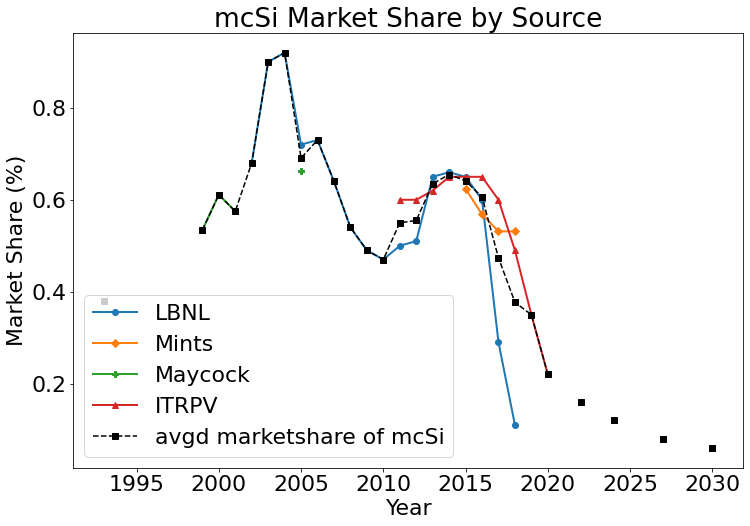

In [11]:
plt.plot(mcSi_cols.index,mcSi_cols[mcSikeys[0]],lw=2,marker='o',label=labelnames_mcSi[0])
plt.plot(mcSi_cols.index,mcSi_cols[mcSikeys[1]],lw=2,marker='D',label=labelnames_mcSi[1])
plt.plot(mcSi_cols.index,mcSi_cols[mcSikeys[2]],lw=2,marker='P',label=labelnames_mcSi[2])
plt.plot(mcSi_cols.index,mcSi_cols[mcSikeys[3]],lw=2,marker='^',label=labelnames_mcSi[3])
plt.plot(est_mrktshrs.index,est_mrktshrs['mcSi'],'--k', marker='s',label='avgd marketshare of mcSi')
plt.legend()
plt.title('mcSi Market Share by Source')
plt.xlabel('Year')
plt.ylabel('Market Share (%)')

### Interpolate and Normalize

Text(0, 0.5, 'Market Share (%)')

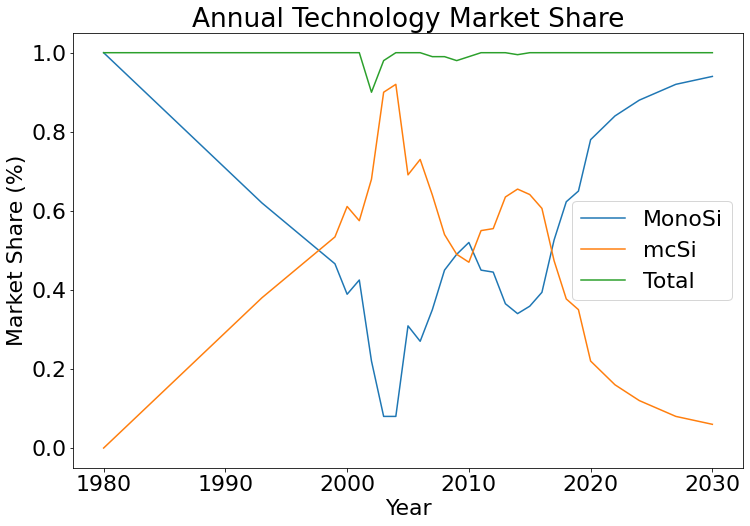

In [12]:
#Interpolate for marketshare NaN values
est_mrktshrs['mcSi'][1980]=0.0
est_mrktshrs = est_mrktshrs.interpolate(method='linear',axis=0,limit_area='inside')

#sanity check of market share data - does it add up?
est_mrktshrs['Total'] = est_mrktshrs.monoSi+est_mrktshrs.mcSi
plt.plot(est_mrktshrs['monoSi'], label='MonoSi')
plt.plot(est_mrktshrs['mcSi'], label='mcSi')
plt.plot(est_mrktshrs['Total'],label='Total')
plt.legend()
plt.title('Annual Technology Market Share')
plt.xlabel('Year')
plt.ylabel('Market Share (%)')
#print(est_mrktshrs)
#Warning: 2002, 10% of the silicon marketshare was "other", including amorphous, etc.
#del est_mrktshrs['Total']

<ipython-input-13-4d824c26ecd2>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_marketshares['Total'] = scaled_marketshares['monoSi']+scaled_marketshares['mcSi']


Text(0, 0.5, 'Market Share (%)')

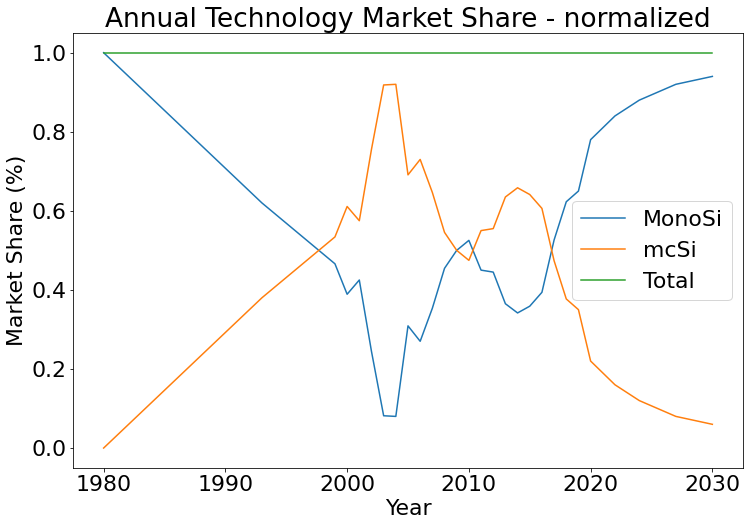

In [13]:
#normalize all marketshares each year to make sure everything adds to 100%
est_mrktshrs['Scale'] = 1/est_mrktshrs['Total']
est_mrktshrs['monoSi_scaled']= est_mrktshrs['Scale']*est_mrktshrs['monoSi']
est_mrktshrs['mcSi_scaled']= est_mrktshrs['Scale']*est_mrktshrs['mcSi']

scaled_marketshares = est_mrktshrs[['monoSi_scaled','mcSi_scaled']]
scaled_marketshares.columns = ['monoSi','mcSi']
scaled_marketshares['Total'] = scaled_marketshares['monoSi']+scaled_marketshares['mcSi']
#print(scaled_marketshares)
plt.plot(scaled_marketshares['monoSi'],label='MonoSi')
plt.plot(scaled_marketshares['mcSi'],label='mcSi')
plt.plot(scaled_marketshares['Total'],label='Total')
plt.legend()
plt.title('Annual Technology Market Share - normalized')
plt.xlabel('Year')
plt.ylabel('Market Share (%)')

Combining Cell Size shares and Market Share Data
----------
Now we have separate mono and mcSi dataframes, which contain the average cell size, based on the market share of the cell size bin as enumerated in ITRPV 2020. The next step is to combine these technology specific (mono vs mc) based on the module technology market share.

Text(0, 0.5, 'Average cell dimension (mm)')

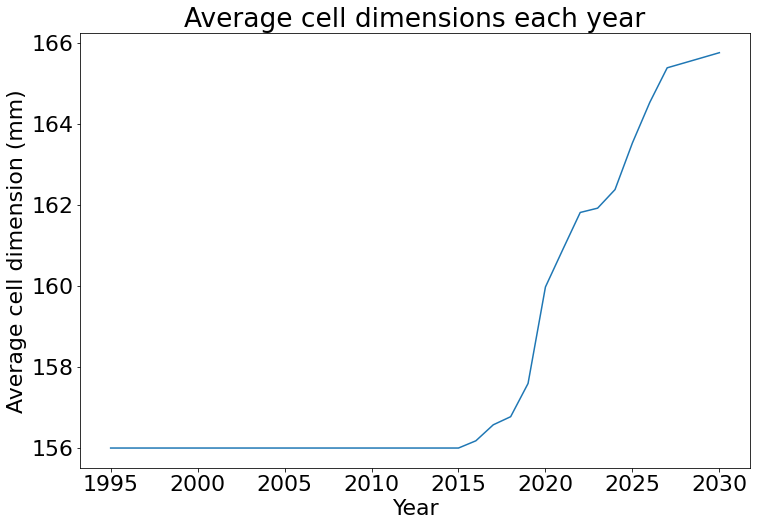

In [14]:
#now combine technology market share of mcSi and monoSi with their respective average cell dimensions
#which have already been cell size marketshare weighted
#going to ignore "otherSi" because for the most part less than 2%, except 2002

#trim the techmarketshare data to 1995 through 2030
est_mrktshrs_sub = scaled_marketshares.loc[est_mrktshrs.index>=1995] #could also use a filter function instead

#multiply the share of each tech by the weighted average cell size
mrkt_wtd_cells = est_mrktshrs_sub.mul(df_avgcell,'columns')
#sum across monoSi and mcSi for the total market average cell size (x and y)
market_average_cell_dims = pd.DataFrame(mrkt_wtd_cells.agg("sum", axis="columns"))
market_average_cell_dims.columns = ['avg_cell']

#print(market_average_cell_dims)
plt.plot(market_average_cell_dims, label='annual average cell dimensions in mm')
#plt.legend()
plt.title('Average cell dimensions each year')
plt.xlabel('Year')
plt.ylabel('Average cell dimension (mm)')

Area of a cell
-------
The above weighted averages are 1 axis dimension of the square cells in a module. Here we create a dataframe of the averge area of a cell for each year.

# CAUTION: assuming squares

In [15]:
df_cellarea_mm2 = market_average_cell_dims.pow(2,axis='columns') #still in mm^2/cell
#you cannot multiply the df.columnname by itself and get a dataframe back, but df.pow returns a dataframe
df_cellarea_mm2.columns = ['avg_cell']
df_cellarea_m2 = df_cellarea_mm2/1000000 #mm^2 to m^2
df_cellarea_cm2 = df_cellarea_mm2/10000 #mm^2 to cm^2
#print(df_cellarea_cm2)

## Calculate cells/m^2 

While there is technology information of # of cells per module (ex: 60, 72), we are looking for the amount of silicon per m^2 of module. Therefore, it will be easier to figure out how many cells at their respective sizes fit into a m^2 rather than scaling up to the module, only to divide by module size. Additionally, the analysis excludes any spacing efficiency factor (i.e. how close the cells are together), as this type of information is not readily available. Therefore, the assumption is the cells are placed close together, leaving no space, which should slightly overestimate the silicon per m^2.

This # cells/ m^2 of module will be used as a factor in the final calculation of g Si/m^2 module.

In [16]:
# calculate # cells/m^2 at this point, rather than using the # cells per module factor
df_cellperm2 = 1/df_cellarea_m2
#print(df_cellperm2)

g of Si per cell
---------
In addition to the number of cells that fit into 1m^2 of module, we need the weight of silicon per cell. First, the weighted average of wafer thickness was calculated for each year based on wafer trends and module type market share in the CE Data google spreadsheet. This data is read in here.

In [17]:
#read in a csv that was copied from CE Data google sheet where the marketshare weighting was done
cwd = os.getcwd() #grabs current working directory
wafer_thickness = pd.read_csv(r'..\..\PV_DEMICE\baselines\SupportingMaterial\Wafer_thickness.csv',index_col='Year')
#this file path navigates from current working directory back up 2 folders, and over to the csv
#convert micron to cm
wafer_thick_cm = wafer_thickness/10000 # microns in a cm
#print(wafer_thick_cm)

In [18]:
#There are missing data, so we will interpolate linearly for missing years
wafer_thick_cm = wafer_thick_cm.interpolate(method='linear',axis=0)
#print(wafer_thick_cm)

Now multiply the thickness of the cell by the area of the cell to get a cell volume for each year

In [19]:
#First, remove 1990 through 1994, to match the size of the cell area df
wafer_thick_cm_1995 = wafer_thick_cm.loc[wafer_thick_cm.index>=1995]
#rename the columns for df.mul operation
wafer_thick_cm_1995.columns = ['avg_cell']
df_cell_volume = df_cellarea_cm2.mul(wafer_thick_cm_1995,'columns')
df_cell_volume.columns = ['cell_volume_cm3']
#print(df_cell_volume)
#plt.plot(df_cell_volume, label='average cell volume (cm^3)')
#plt.legend()

Now we have the volume of the cell in cm^3 for each year, we can bring in the density of Silicon to get a mass of Silicon per cell for each year.

Text(0, 0.5, 'Silicon (grams/cell)')

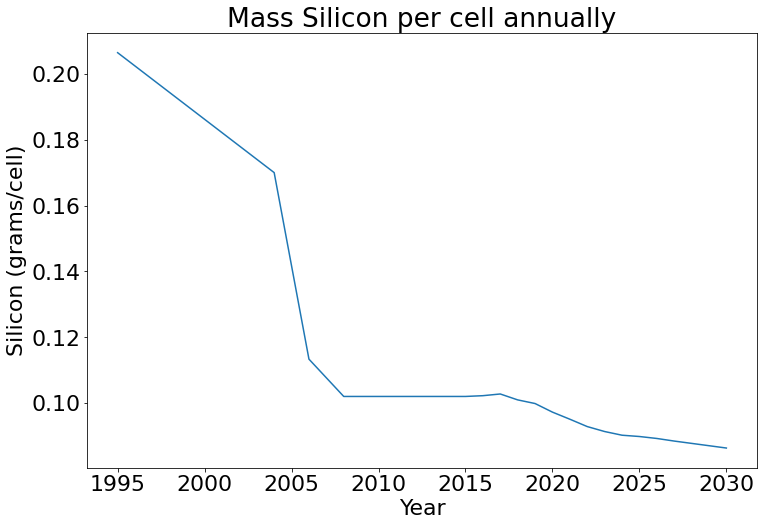

In [20]:
df_Simass_percell = df_cell_volume.mul(density_si)
df_Simass_percell.columns = ['Si_gpercell']
#print(df_Simass_percell)
plt.plot(df_Simass_percell, label='Mass Si per cell (g/cell)')
#plt.legend()
plt.title('Mass Silicon per cell annually')
plt.xlabel('Year')
plt.ylabel('Silicon (grams/cell)')

## g Si per m^2 of module

Now take the above mass of silicon per cell and multiply it by the factor of number of cells per m^2 of module

Text(0, 0.5, 'Silicon (grams/m^2)')

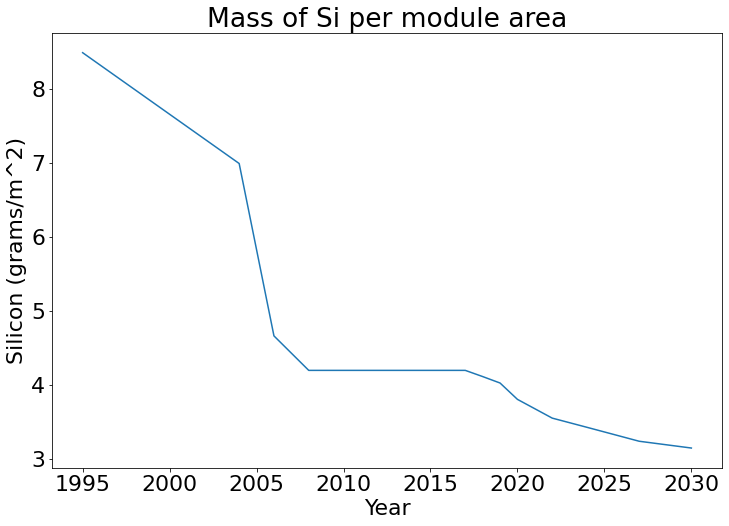

In [21]:
df_Simass_percell.columns = df_cellperm2.columns = ['Si_g'] #rename to a common name
df_Simass_perm2 = df_Simass_percell.mul(df_cellperm2, 'columns') #multiply
#print(df_Simass_perm2)
#print out to a csv
df_Simass_perm2.to_csv(os.path.join(supportingmaterial,'si_g_per_m2.csv'), index=True)

#make a pretty plot
plt.plot(df_Simass_perm2, label='Silicon g/m^2 of module')
#plt.legend()
plt.title('Mass of Si per module area')
plt.xlabel('Year')
plt.ylabel('Silicon (grams/m^2)')